En este código se encuentra el paso a paso de nuestro proyecto final del máster, en el que se extraen datos de distintas API's para lograr compilar datos y lograr armar un modelo para predecir la probabilidad de que USA entre en recesión económica

In [11]:
# !python -m pip install scikit-learn

In [22]:
import requests
import pandas as pd
from fred_key import fred_key
import openpyxl
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

__DESCRIPCION DE VARIABLES__

- __VIX:__
Índice de volatilidad, tiende a aumentar durante períodos de turbulencia financiera o incertidumbre del mercado.

Relación con USREC: Durante períodos de recesión económica, la volatilidad en los mercados financieros tiende a aumentar, ya que los inversores se vuelven más preocupados y los precios de las acciones pueden experimentar movimientos abruptos. Por lo tanto, se espera que el VIX tenga una relación inversa con la variable objetivo USREC: cuando el VIX aumenta, es más probable que estemos en una recesión económica.

- __UNRATE:__
Tasa de desempleo, es una medida que indica el porcentaje de la fuerza laboral total que está desempleada pero buscando activamente empleo. 

Relación con USREC: Durante las recesiones económicas, la tasa de desempleo tiende a aumentar a medida que las empresas reducen la contratación y los trabajadores pierden sus empleos. Por lo tanto, se espera que la tasa de desempleo tenga una relación positiva con la variable objetivo USREC: cuando la tasa de desempleo aumenta, es más probable que estemos en una recesión económica.

- __FEDFUNDS:__
Tasa de fondos federales, es la tasa de interés a corto plazo a la cual los bancos prestan dinero entre sí de la Reserva Federal. Es una de las herramientas clave utilizadas por la Reserva Federal para controlar la política monetaria y afecta a las tasas de interés en toda la economía.

Relación con USREC: Durante las recesiones económicas, la Reserva Federal a menudo reduce las tasas de interés para estimular la actividad económica y fomentar la inversión y el gasto. Por lo tanto, se espera que las tasas de interés tengan una relación negativa con la variable objetivo USREC: cuando las tasas de interés disminuyen, es más probable que estemos en una recesión económica.

- __YIELD CURVE:__
Tasa de rendimiento de los bonos del Tesoro a 10 años menos la tasa de rendimiento de los bonos del Tesoro a 2 años, también conocida como "spread" entre los bonos del Tesoro a 10 y 2 años. Este indicador se utiliza a menudo como una medida de las expectativas del mercado sobre la dirección futura de la economía.

Relación con USREC: Un spread de rendimiento estrecho o negativo entre los bonos del Tesoro a largo y corto plazo a menudo se interpreta como una señal de debilidad económica o una posible recesión. Por lo tanto, se espera que el spread entre los bonos del Tesoro tenga una relación positiva con la variable objetivo USREC: cuando el spread se estrecha o se vuelve negativo, es más probable que estemos en una recesión económica.

- __M2__:
Money Stock es una medida de la cantidad total de dinero en circulación en la economía que incluye el efectivo, los depósitos a la vista y a plazo en bancos comerciales, y otros activos líquidos. Es una medida amplia de la oferta monetaria y es monitoreada de cerca por los bancos centrales y los economistas como un indicador de la liquidez y la disponibilidad de crédito en la economía.

Relación con USREC: Durante las recesiones económicas, la cantidad de dinero en circulación y la disponibilidad de crédito pueden disminuir a medida que las instituciones financieras se vuelven más reacias a prestar y los consumidores reducen su gasto. Por lo tanto, se espera que la M2 Money Stock tenga una relación negativa con la variable objetivo USREC: cuando la M2 Money Stock disminuye, es más probable que estemos en una recesión económica.

- __PER CAPITA CONSUMPTION:__
Per Capita Consumption es una medida del gasto total de consumo en la economía dividido por la población total, lo que proporciona una estimación del gasto promedio por persona. Es una medida clave del nivel de vida y el comportamiento de gasto de los consumidores en una economía.


Relación con USREC: Durante las recesiones económicas, el gasto de consumo tiende a disminuir a medida que los consumidores reducen su gasto en bienes y servicios discrecionales y tienden a ahorrar más en respuesta a la incertidumbre económica y laboral. Por lo tanto, se espera que el Per Capita Consumption tenga una relación negativa con la variable objetivo USREC: cuando el gasto de consumo per cápita disminuye, es más probable que estemos en una recesión económica.

- __CONSUMER PRICE INDEX:__
Consumer Price Index (CPI) es una medida del nivel promedio de precios de bienes y servicios de consumo en la economía. Se utiliza para medir la inflación y es un indicador importante de la estabilidad de precios y el poder adquisitivo del consumidor.

Relación con USREC: Durante las recesiones económicas, la inflación tiende a disminuir a medida que la demanda de bienes y servicios se debilita y la capacidad excedente en la economía aumenta la presión a la baja sobre los precios. Por lo tanto, se espera que el Consumer Price Index tenga una relación negativa con la variable objetivo USREC: cuando la inflación disminuye, es más probable que estemos en una recesión económica.

- __S&P 500:__
índice bursátil que sigue el rendimiento de 500 de las empresas más grandes y ampliamente negociadas en los Estados Unidos. Estas empresas representan una amplia gama de sectores de la economía y son seleccionadas por su tamaño de mercado, liquidez y representatividad de la economía estadounidense. El S&P 500 es considerado uno de los principales indicadores del desempeño del mercado de valores de los Estados Unidos y es ampliamente utilizado como referencia por inversores y analistas.

Relación con USREC: La relación entre el S&P 500 y la variable objetivo USREC (indicador de recesión) puede ser más compleja que las otras variables mencionadas anteriormente. En general, durante las recesiones económicas, el S&P 500 tiende a experimentar caídas significativas a medida que los inversores se vuelven más cautelosos y los beneficios corporativos se ven afectados por la desaceleración económica. Sin embargo, también es importante tener en cuenta que los movimientos del mercado de valores pueden anticipar cambios en la economía real, y las políticas monetarias y fiscales pueden influir en la dirección del mercado. Por lo tanto, aunque una caída significativa en el S&P 500 puede indicar preocupaciones sobre una recesión, no siempre es un indicador directo de la economía real y puede haber otros factores en juego.

In [13]:
today_date = datetime.today().strftime('%Y-%m-%d')

In [14]:
api_key = fred_key

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

# Define indicators and their corresponding FRED series IDs
indicators = {
   'VIX': 'VIXCLS', #Daily #1976-06-01
   'Unemployment': 'UNRATE', #Montlhy #1948-01-01
   #'S&P500': 'SP500', #Daily #1920
   'Interest_Rates': 'FEDFUNDS', #Montlhy #1954-07-01
   'YIC':'T10Y2Y', #Daily #1976-06-01 
   'M2 MONEY STOCK': 'M2',
   'PER CAPITA CONSUMPTION': 'PCEPILFE',
   'CONSUMER PRICE INDEX': 'CPIAUCNS',
      'USREC_1' : 'USREC', #Monthly #1854-12-01,
}

# Assign common parameters
start_date = '1993-02-01'
end_date = today_date
#
file_type = 'json'
ts_frequency = 'm'
#ts_units = 'pc1' #percentaje value from last year

# Fetch data for each indicator
data_frames = {}
for indicator, series_id in indicators.items():
    obs_params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': file_type,
        'observation_start': start_date,
        'observation_end': end_date,
        'frequency': ts_frequency,
        #'units': ts_units #percentaje value from last year
    }

    # Make request to FRED API
    response = requests.get(base_url + 'series/observations', params=obs_params)

    # Create DataFrame for each indicator
    if response.status_code == 200:
        res_data = response.json()
        obs_data = pd.DataFrame(res_data['observations'])
        obs_data['date'] = pd.to_datetime(obs_data['date'])
        obs_data.set_index('date', inplace=True)
        obs_data['value'] = obs_data['value']
        data_frames[indicator] = obs_data
    else:
        print(f'Failed to retrieve data for {indicator}. Status code:', response.status_code)

El siguiente código sirve para descargar el SP&500 utilizando la API yfinance

In [15]:
today_date = datetime.today().strftime('%Y-%m-%d')


spy_ohlc_df = yf.download('SPY', start='1977-06-01', end=today_date, interval='1mo')


#Reset Index
spy_ohlc_df.reset_index(inplace=True)

# Crear el dataframe con las columnas de fecha y cierre del índice
new_spy = pd.DataFrame({
    'Date': spy_ohlc_df['Date'],  
    'Close': spy_ohlc_df['Close']  
})

new_spy['Close']

[*********************100%%**********************]  1 of 1 completed


0       44.406250
1       45.187500
2       44.031250
3       45.218750
4       45.062500
          ...    
370    475.309998
371    482.880005
372    508.079987
373    523.070007
374    519.409973
Name: Close, Length: 375, dtype: float64

Para descargar los datos desde la API de la FRED:

In [16]:
# Display the modified DataFrames for each indicator
for indicator, df in data_frames.items():
    # Create a modified DataFrame by dropping specified columns
    modified_df = df.drop(['realtime_start', 'realtime_end'], axis=1)
    
    # Store the modified DataFrame in the dictionary
    data_frames[indicator] = modified_df


# Concatenar los DataFrames
combined_df = pd.concat(data_frames.values(), axis=1, keys=data_frames.keys())

# Eliminar el nivel de nombre 'value' de las columnas
combined_df.columns = combined_df.columns.droplevel(1)
# combined_df.columns = combined_df.columns.droplevel(2)

combined_df['SP500'] = new_spy['Close'].values

combined_df['USREC'] = combined_df['USREC_1']

combined_df = combined_df.drop('USREC_1', axis = 1)

# Reset Index
combined_df.reset_index(inplace=True)


combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,SP500,USREC
0,1993-02-01,13.72,7.1,3.03,2.16,3413.8,65.557,143.1,44.406250,0
1,1993-03-01,13.61,7.0,3.07,2.03,3411.3,65.7,143.6,45.187500,0
2,1993-04-01,12.84,7.1,2.96,2.13,3408.9,65.891,144.0,44.031250,0
3,1993-05-01,13.61,7.1,3.00,2.06,3436.0,66.114,144.2,45.218750,0
4,1993-06-01,12.52,7.0,3.04,1.80,3442.8,66.177,144.4,45.062500,0
...,...,...,...,...,...,...,...,...,...,...
370,2023-12-01,12.72,3.7,5.33,-0.44,NaN,120.305,306.746,475.309998,0
371,2024-01-01,13.39,3.7,5.33,-0.26,NaN,120.849,308.417,482.880005,0
372,2024-02-01,13.98,3.9,5.33,-0.34,NaN,121.165,310.326,508.079987,0
373,2024-03-01,13.79,NaN,5.33,-0.38,NaN,NaN,NaN,523.070007,0


In [17]:

# Seleccionar las columnas que deseas convertir a float64
columnas = combined_df.columns[1:]

# Iterar sobre cada columna seleccionada y convertir los valores numéricos a tipo float64
for col in columnas:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df = combined_df.dropna()

combined_df
# combined_df.to_excel('dataframe.xlsx')


,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,SP500,USREC
0,1993-02-01,13.72,7.1,3.03,2.16,3413.8,65.557,143.100,44.406250,0.0
1,1993-03-01,13.61,7.0,3.07,2.03,3411.3,65.700,143.600,45.187500,0.0
2,1993-04-01,12.84,7.1,2.96,2.13,3408.9,65.891,144.000,44.031250,0.0
3,1993-05-01,13.61,7.1,3.00,2.06,3436.0,66.114,144.200,45.218750,0.0
4,1993-06-01,12.52,7.0,3.04,1.80,3442.8,66.177,144.400,45.062500,0.0
...,...,...,...,...,...,...,...,...,...,...
331,2020-09-01,27.65,7.8,0.09,0.54,18589.2,105.390,260.280,334.890015,0.0
332,2020-10-01,29.44,6.8,0.09,0.64,18692.4,105.470,260.388,326.540009,0.0
333,2020-11-01,25.00,6.7,0.09,0.70,18915.4,105.552,260.229,362.059998,0.0
334,2020-12-01,22.37,6.7,0.09,0.80,19051.5,105.899,260.474,373.880005,0.0


In [18]:
combined_df.to_excel('dataframe.xlsx', index = False)

In [19]:

# Convertir la columna de fechas a una representación numérica antes de la división de datos
combined_df['date'] = combined_df['date'].astype('int64')

scaler = StandardScaler()

# Normalizar el DataFrame excepto la columna 'date'
columns_to_normalize = combined_df.columns.difference(['date','USREC'])  # Excluir la columna 'date'
combined_df[columns_to_normalize] = scaler.fit_transform(combined_df[columns_to_normalize])

# Suponiendo que df contiene tu DataFrame original con los datos
X = combined_df.drop('USREC', axis=1)
y = combined_df['USREC']

combined_df


C:\Users\ejvia\AppData\Local\Temp\ipykernel_25196\3655788787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['date'] = combined_df['date'].astype('int64')
C:\Users\ejvia\AppData\Local\Temp\ipykernel_25196\3655788787.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[columns_to_normalize] = scaler.fit_transform(combined_df[columns_to_normalize])


,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,SP500,USREC
0,728524800000000000,-0.728593,0.710195,0.242388,1.185703,-1.191624,-1.670870,-1.679759,-1.385165,0.0
1,730944000000000000,-0.742284,0.654167,0.260629,1.037371,-1.192254,-1.658603,-1.665602,-1.374364,0.0
2,733622400000000000,-0.838125,0.710195,0.210466,1.151472,-1.192859,-1.642219,-1.654277,-1.390350,0.0
3,736214400000000000,-0.742284,0.710195,0.228707,1.071601,-1.186026,-1.623089,-1.648614,-1.373932,0.0
4,738892800000000000,-0.877955,0.654167,0.246949,0.774938,-1.184312,-1.617685,-1.642952,-1.376092,0.0
...,...,...,...,...,...,...,...,...,...,...
331,1598918400000000000,1.005254,1.102395,-1.098341,-0.662738,2.634806,1.746108,1.637974,2.631025,0.0
332,1601510400000000000,1.228052,0.542110,-1.098341,-0.548637,2.660827,1.752971,1.641032,2.515579,0.0
333,1604188800000000000,0.675412,0.486081,-1.098341,-0.480176,2.717056,1.760005,1.636530,3.006674,0.0
334,1606780800000000000,0.348060,0.486081,-1.098341,-0.366075,2.751373,1.789772,1.643466,3.170096,0.0


<Figure size 1200x800 with 0 Axes>

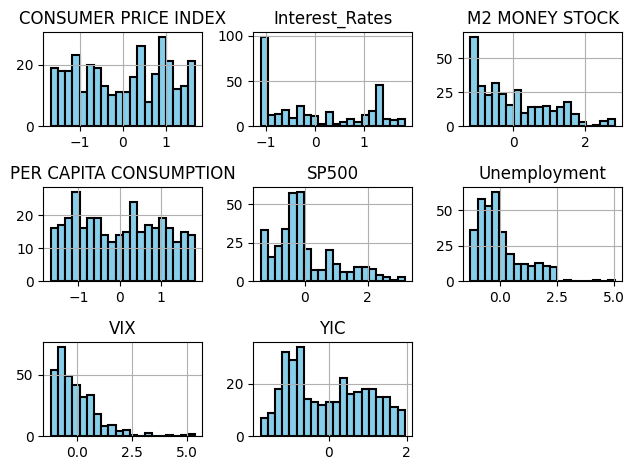

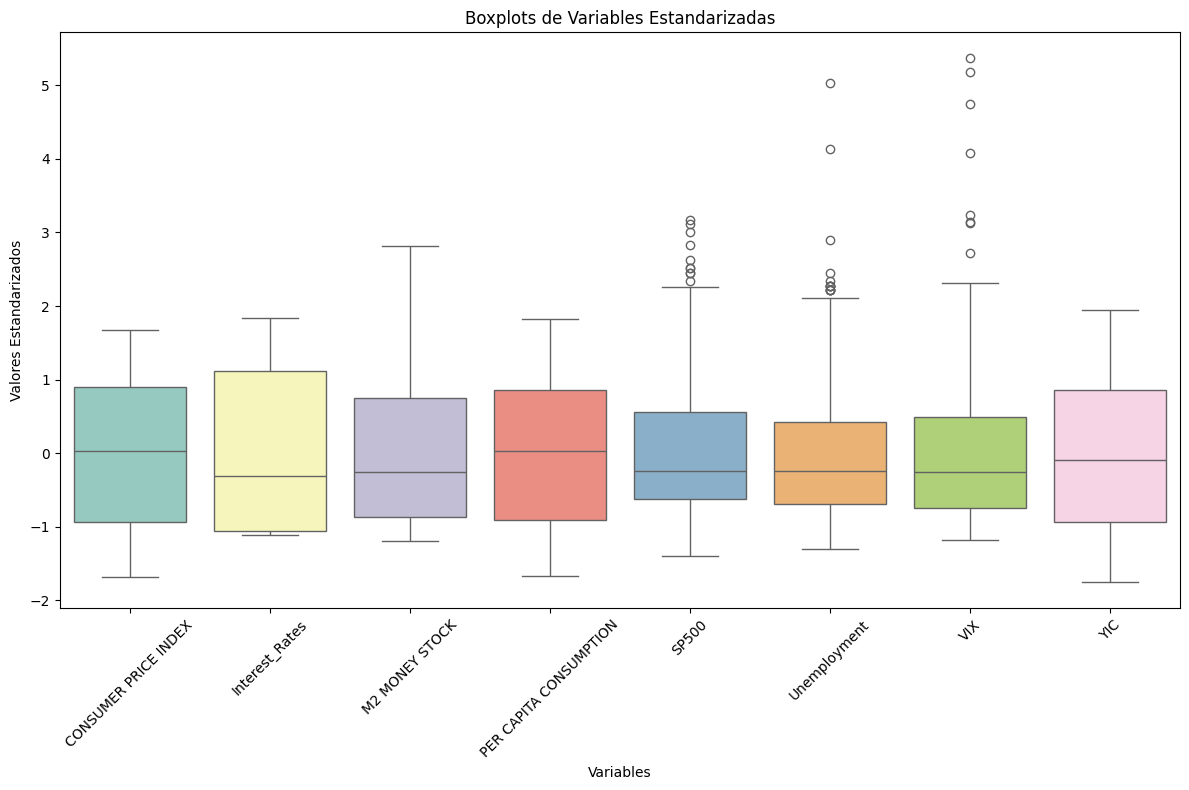

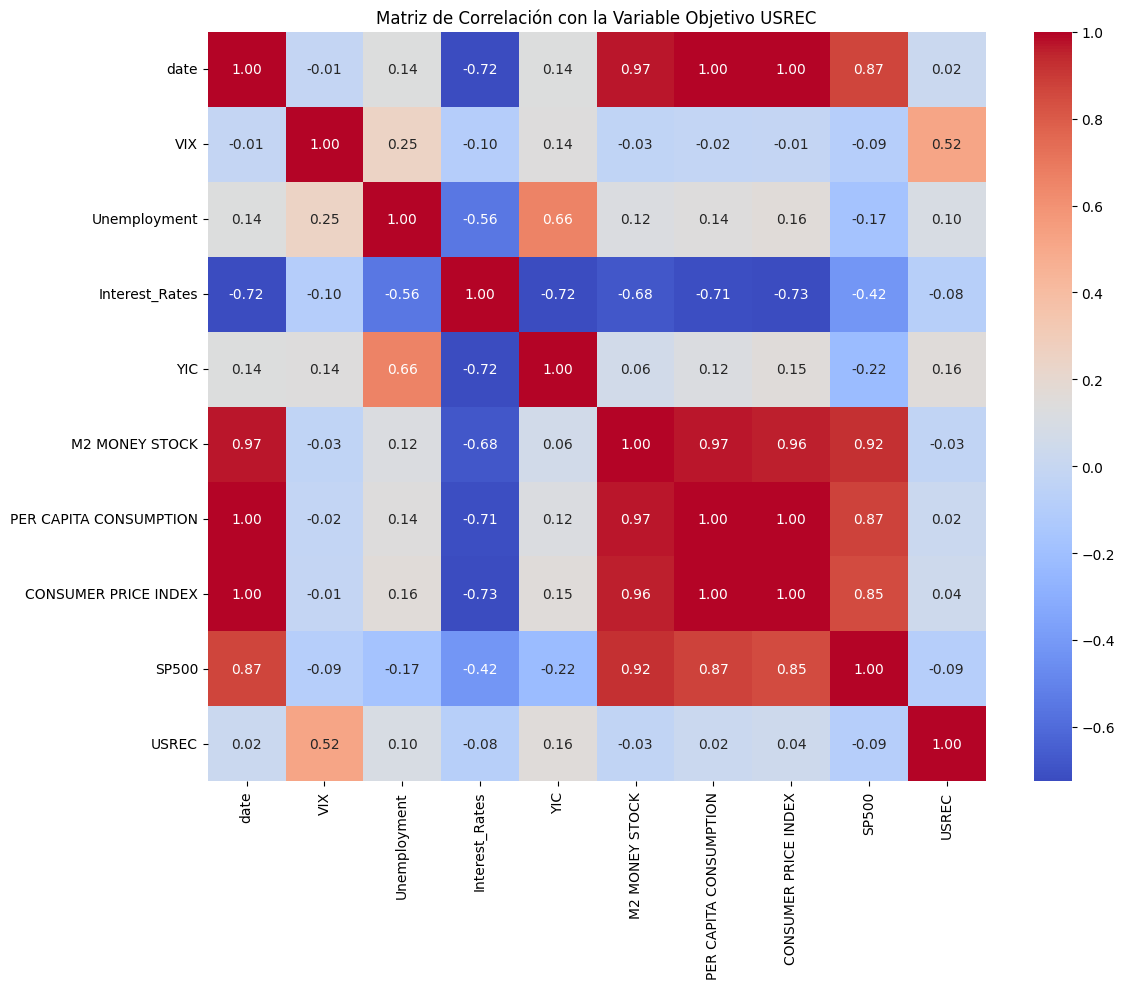

In [20]:

# Histogramas de las variables estandarizadas
plt.figure(figsize=(12, 8))
combined_df[columns_to_normalize].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.5)
plt.title('Histogramas de Variables Estandarizadas')
plt.xlabel('Valores Estandarizados')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Boxplots de las variables estandarizadas
plt.figure(figsize=(12, 8))
sns.boxplot(data=combined_df[columns_to_normalize], palette='Set3')
plt.title('Boxplots de Variables Estandarizadas')
plt.xlabel('Variables')
plt.ylabel('Valores Estandarizados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Matriz de correlación con la variable objetivo 'USREC'
plt.figure(figsize=(12, 10))
correlation_matrix = combined_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación con la Variable Objetivo USREC')
plt.tight_layout()
plt.show()


In [23]:
X = combined_df.drop('USREC', axis=1)
y = combined_df['USREC']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest para regresión
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_regressor.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)

Error cuadrático medio: 0.03873235294117647


In [24]:
print(y_pred)

[0.06 0.   0.   0.05 0.   0.   0.   0.   0.   0.   0.26 0.   0.   0.03
 0.01 0.5  0.   0.   0.72 0.   0.   0.   0.   0.36 0.06 0.   0.   0.
 0.   0.15 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.36 0.
 0.54 0.08 0.06 0.   0.   0.08 0.67 0.   0.17 0.   0.   0.   0.05 0.01
 0.   0.79 0.52 0.   0.   0.05 0.86 0.   0.   0.02 0.   0.  ]


In [28]:
test_2 = combined_df.drop('USREC',axis = 1)

test_pred = rf_regressor.predict(test_2)



In [29]:
test_pred

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.16, 0.36, 0.06, 0.  ,
       0.02, 0.08, 0.07, 0.  , 0.01, 0.02, 0.06, 0.  , 0.01, 0.  , 0.01,
       0.08, 0.03, 0.  , 0.  , 0.03, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.07, 0.62,
       0.77, 0.83, 0.72, 0.83, 0.98, 0.96, 0.81, 0.11, 0.04, 0.05, 0.  ,
       0.  , 0.  , 0.03, 0.15, 0.15, 0.1 , 0.17, 0.1 , 0.06, 0.01, 0.06,
       0.05, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [ ]:
final_test = test_2

final_test['PREDICTION'] = 